> # 1. Importing needed packages

In [1]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
import seaborn as sns
import pydot
from PIL import Image
import matplotlib.pyplot as plt
import plotly.express as px
import tensorflow as tf
import matplotlib.image as mpimg
import random
import time
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from keras.applications.vgg16 import VGG16
from keras.layers import Flatten, Dense
from keras.models import Model
from sklearn.metrics import classification_report
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

> # 2. Implimentation of useful functions

In [2]:
def count_images_and_plot(directory):
    for split in [ 'test','train','val']:
        split_dir = os.path.join(directory, split)
        total_count = 0
        class_counts = {}
        for class_dir in os.listdir(split_dir):
            class_path = os.path.join(split_dir, class_dir)
            count = len(os.listdir(class_path))
            total_count += count
            class_counts[class_dir] = count
            
        print(f"Directory: {split}")
        print(f"Total number of images: {total_count}")
        print("Number of images per class:")
        for class_dir, count in class_counts.items():
            print(f"- Class {class_dir}: {count}")
        
        fig = px.bar(x=list(class_counts.keys()), y=list(class_counts.values()), 
                     labels={'x': 'Class', 'y': 'Number of Images'},
                     title=f"Distribution of Classes in {split} Directory")
        fig.show()


In [3]:
def display_images(path):
    class_names0 = os.listdir(path)
    class_names = sorted(class_names0)
    image_files = [[os.path.join(path, class_name, x) 
                   for x in os.listdir(os.path.join(path, class_name))] 
                   for class_name in class_names]
    image_file_list = []
    image_label_list = []
    for i, class_name in enumerate(class_names):
        image_file_list.extend(image_files[i])
        image_label_list.extend([i] * len(image_files[i]))
    num_total=len(image_file_list)
    plt.subplots(3,3, figsize=(12,12))
    for i,k in enumerate(np.random.randint(num_total, size=9)):
        im = Image.open(image_file_list[k])
        arr = np.array(im)
        #print(arr.shape)
        plt.subplot(3,3, i+1)
        plt.xlabel(class_names[image_label_list[k]])
        plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
    plt.tight_layout()
    plt.show()


In [4]:
def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

In [5]:
def visualize_model(model,file_name='model.png'):
    """
    Visualizes a Keras model using pydot.
    """
    return tf.keras.utils.plot_model(model, to_file=file_name, show_shapes=True, show_layer_names=True)
    

In [6]:
def plot_loss_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = list(range(len(history.history['loss'])))

    fig = make_subplots(rows=1, cols=2, subplot_titles=("Loss", "Accuracy"))

    # Plot loss
    fig.add_trace(go.Scatter(x=epochs, y=loss, mode='lines', name='Training Loss'), row=1, col=1)
    fig.add_trace(go.Scatter(x=epochs, y=val_loss, mode='lines', name='Validation Loss'), row=1, col=1)

    # Plot accuracy
    fig.add_trace(go.Scatter(x=epochs, y=accuracy, mode='lines', name='Training Accuracy'), row=1, col=2)
    fig.add_trace(go.Scatter(x=epochs, y=val_accuracy, mode='lines', name='Validation Accuracy'), row=1, col=2)

    fig.update_layout(height=500, width=1000, title='Training History')
    fig.show()


> # 3. Getting the data

You can access and download the data from this link: **[Dataset](https://www.kaggle.com/datasets/puneet6060/intel-image-classification)**
This Data contains around 25k images of size 150x150 distributed under 6 categories.
+ Buildings
+ Forest
+ Glacier
+ Mountain
+ Sea
+ Street

_After obtaining the data, we split the training set into two sets - the actual training set and the validation set_

In [7]:
ls data

 Volume in drive C has no label.
 Volume Serial Number is 00AA-4C59

 Directory of C:\Users\T470P\Desktop\TL\data\data

05/07/2023  10:10 AM    <DIR>          .
05/07/2023  10:10 AM    <DIR>          ..
05/07/2023  10:11 AM    <DIR>          other
05/07/2023  02:49 AM    <DIR>          test
05/07/2023  10:10 AM    <DIR>          train
05/07/2023  10:08 AM    <DIR>          val
               0 File(s)              0 bytes
               6 Dir(s)  17,872,121,856 bytes free


The file structure has been formatted to be in a typical format you might use for working with images.

More specifically:

A train directory which contains all of the images in the training dataset with subdirectories each named after a certain class containing images of that class.
A test and val directories with the same structure as the train directory.

> # 4. Analyzing dataset and class distribution across test, train, and validation sets

In [8]:
count_images_and_plot('data')

Directory: test
Total number of images: 3000
Number of images per class:
- Class buildings: 437
- Class forest: 474
- Class glacier: 553
- Class mountain: 525
- Class sea: 510
- Class street: 501


Directory: train
Total number of images: 4214
Number of images per class:
- Class buildings: 658
- Class forest: 682
- Class glacier: 722
- Class mountain: 754
- Class sea: 683
- Class street: 715


Directory: val
Total number of images: 985
Number of images per class:
- Class buildings: 154
- Class forest: 159
- Class glacier: 169
- Class mountain: 176
- Class sea: 160
- Class street: 167


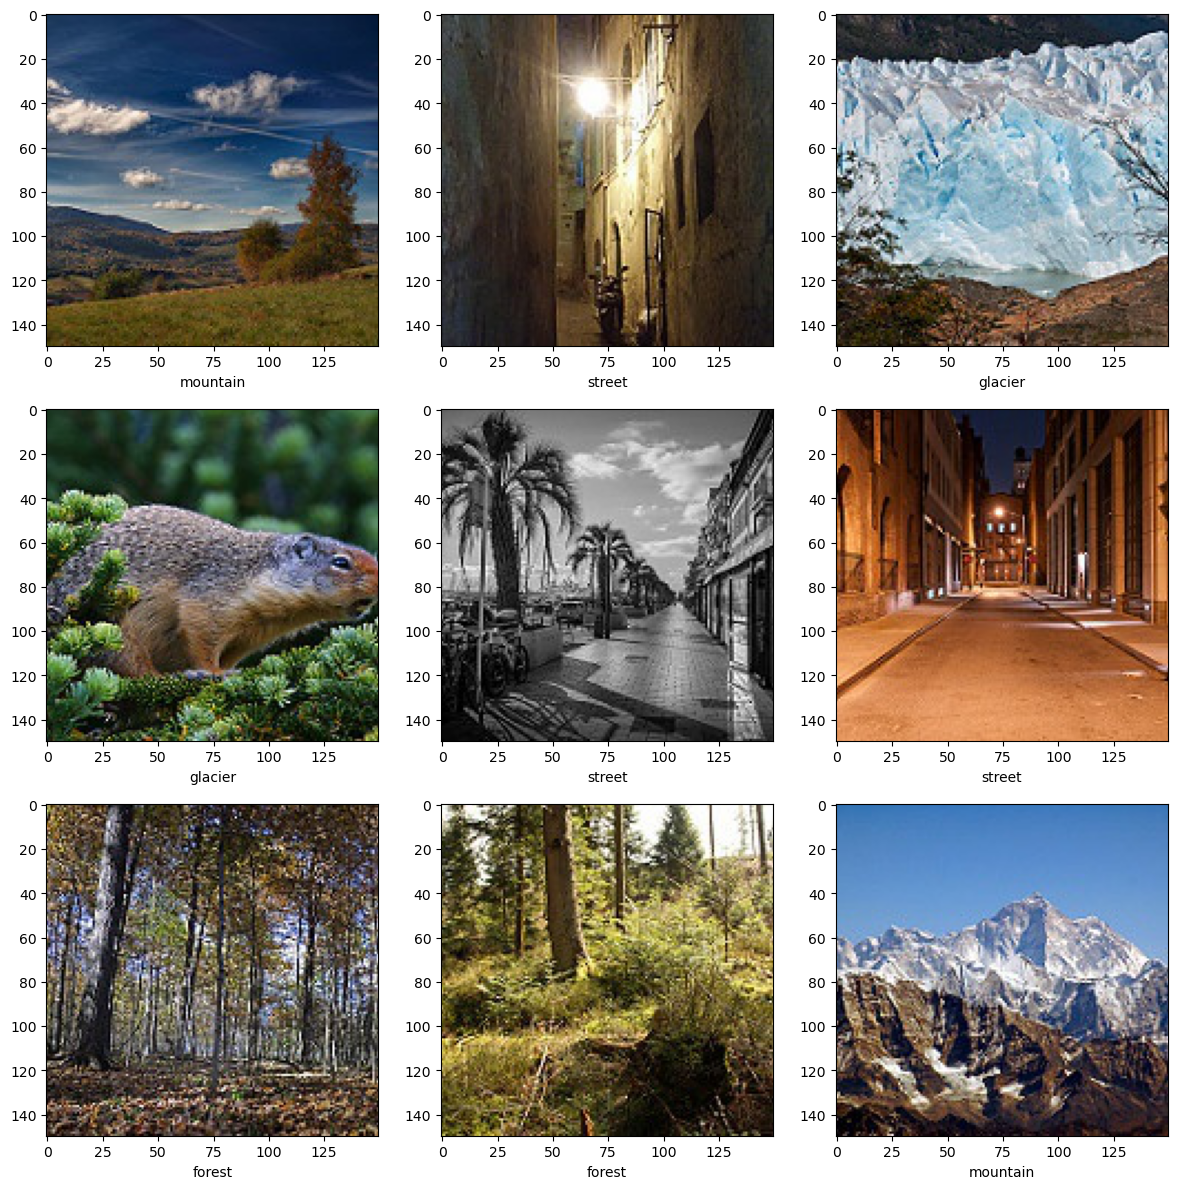

In [9]:
display_images('data/train')

After examining the class distribution in the training set, we have observed that the classes are not highly imbalanced, but there are some disparities present.
We will use the class weight method to address the imbalance issue. This method involves assigning a weight to each class, with the weights being inversely proportional to the frequency of samples in each class. The model is then trained using these weights, which give more importance to the underrepresented classes. In practical terms, we can calculate the class weights using a simple formula, and then pass them to the model during training as a parameter. This approach helps to ensure that the model does not become biased towards the more common classes, and can lead to improved performance on the minority classes."
$$ class\_weight = \frac{total\_samples}{num\_classes * class\_samples}$$
where:
+ total_samples is the total number of samples in the dataset
+ num_classes is the total number of classes
+ class_samples is the number of samples in a specific class

> # 5. Overview the data

Image shape: (150, 150, 3)


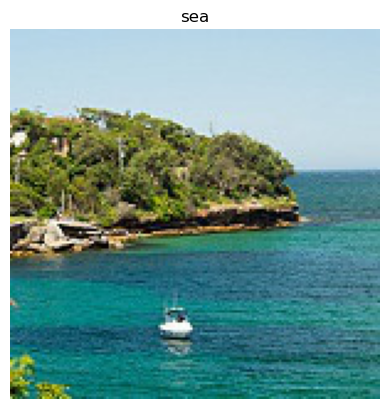

In [10]:
img = view_random_image(target_dir="data/train/",
                        target_class="sea")

In [11]:
img.shape

(150, 150, 3)

In [12]:
img

array([[[179, 211, 232],
        [179, 212, 231],
        [179, 212, 231],
        ...,
        [178, 211, 230],
        [179, 212, 231],
        [179, 212, 231]],

       [[179, 211, 232],
        [179, 212, 231],
        [179, 212, 231],
        ...,
        [178, 211, 230],
        [179, 212, 231],
        [179, 212, 231]],

       [[180, 212, 233],
        [180, 213, 232],
        [180, 213, 232],
        ...,
        [178, 211, 230],
        [179, 212, 231],
        [179, 212, 231]],

       ...,

       [[ 32,  30,   7],
        [  1,   8,   0],
        [ 25,  46,  27],
        ...,
        [ 59, 138, 135],
        [ 58, 136, 136],
        [ 58, 136, 138]],

       [[ 85, 100,  41],
        [ 83, 108,  51],
        [ 47,  87,  37],
        ...,
        [ 33, 124, 117],
        [ 37, 128, 123],
        [ 35, 125, 123]],

       [[171, 202, 126],
        [ 41,  78,   1],
        [ 74, 124,  55],
        ...,
        [ 14, 114, 104],
        [ 24, 125, 117],
        [ 17, 118, 112]]

In [13]:
np.max(img)

255

In [14]:
np.min(img)

0

**As discussed before, many machine learning models, including neural networks prefer the values they work with to be between 0 and 1. Knowing this, one of the most common preprocessing steps for working with images is to scale (also referred to as normalize) their pixel values by dividing the image arrays by 255.**

In [15]:
img/255

array([[[0.70196078, 0.82745098, 0.90980392],
        [0.70196078, 0.83137255, 0.90588235],
        [0.70196078, 0.83137255, 0.90588235],
        ...,
        [0.69803922, 0.82745098, 0.90196078],
        [0.70196078, 0.83137255, 0.90588235],
        [0.70196078, 0.83137255, 0.90588235]],

       [[0.70196078, 0.82745098, 0.90980392],
        [0.70196078, 0.83137255, 0.90588235],
        [0.70196078, 0.83137255, 0.90588235],
        ...,
        [0.69803922, 0.82745098, 0.90196078],
        [0.70196078, 0.83137255, 0.90588235],
        [0.70196078, 0.83137255, 0.90588235]],

       [[0.70588235, 0.83137255, 0.91372549],
        [0.70588235, 0.83529412, 0.90980392],
        [0.70588235, 0.83529412, 0.90980392],
        ...,
        [0.69803922, 0.82745098, 0.90196078],
        [0.70196078, 0.83137255, 0.90588235],
        [0.70196078, 0.83137255, 0.90588235]],

       ...,

       [[0.1254902 , 0.11764706, 0.02745098],
        [0.00392157, 0.03137255, 0.        ],
        [0.09803922, 0

> # 6. Importting and preprocessing the data

In [16]:
train_dir = 'data/train'
val_dir = 'data/val'
test_dir = 'data/test'

In [17]:
# Define image size
img_size = (150, 150)

# Define batch size
batch_size = 32

Our next step is to transform our data into batches. A batch is a small subset of the dataset that a model looks at during training. For example, rather than looking at 10,000 images at once and trying to make sense of them, a model may only look at 32 images at a time. It does this for several reasons:

+ 1200 images (or more) may not fit in the memory of your processor (GPU).
+ Trying to learn patterns from 1200 images at once could prevent the model from learning very well.

There are many different batch sizes you can use, but 32 has been found to be very effective in many different use cases and is often the default value for many data preprocessing functions. To transform the data into batches, we will first create an instance of ImageDataGenerator for each of our datasets.
+ To turn our data into batches, we'll first create an instance of **ImageDataGenerator** for each of our datasets.
+ Then, we can load images from their respective directories using **the flow_from_directory method**.

In [18]:
#train dataset

train_datagen = ImageDataGenerator(
    rescale=1./255)  

train_data = train_datagen.flow_from_directory(
    train_dir,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    target_size=img_size)

Found 4214 images belonging to 6 classes.


In [19]:
# validatation dataset

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    )  

validation_data = validation_datagen.flow_from_directory(
    val_dir,
    batch_size=batch_size,
    target_size=img_size,
    shuffle=True,
    class_mode='categorical')


Found 985 images belonging to 6 classes.


In [20]:
#test dataset

test_datagen = ImageDataGenerator(
    rescale=1./255,
    )  

test_data = test_datagen.flow_from_directory(
    test_dir,
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical',
    target_size=img_size)

Found 3000 images belonging to 6 classes.


The **rescale** parameter, along with **1/255**. is like saying **"divide all of the pixel values by 255"**. This results in all of the image being imported and their pixel values being normalized (converted to be between 0 and 1).

+ Due to how directories are structured, the classes get inferred by the subdirectory names in train_dir, val_dir and test_dir.
+ The target_size parameter defines the input size of our images in (height, width) format.
+ The class_mode value of 'categorical' defines our classification problem type. If we had two classes, we would use 'binary'.
+ The batch_size defines how many images will be in each batch, we've used 32 which is the same as the default.

**We can take a look at our batched images and labels by inspecting the train_data object.**

In [21]:
images, labels = train_data.next() # get the 'next' batch of images/labels
len(images), len(labels)

(32, 32)

In [22]:
labels

array([[0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       [0.

> # 7. Create model

As our lab topic is about transfer learning (sujet 8), we will not create a model from scratch. Instead, we will demonstrate the high accuracy rates that can be achieved by using predefined models for transfer learning. In our lab report, we discussed two different methods of transfer learning: feature extraction and fine-tuning. For each method, we will provide an example of using different pre-trained models that were trained on the ImageNet dataset.

> ## 7.1 Setting up callbacks (things to run whilst our model trains)

Before we build a model, there's an important concept that play a key role in our future model building experiments.
And that concept is callbacks.
Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks include:
<hr/>
+ ModelCheckpoint: This callback is used to save the model weights at certain points during training. It accepts several arguments, including:
<br/>
<ul>
<li> Filepath: The path where the model weights will be saved.</li>
<li> Monitor: The metric to monitor. In this case, it is set to 'val_accuracy', meaning the validation accuracy will be used to determine if the current model is the best one.</li>
<li>Save_weights_only: If set to True, only the weights of the model will be saved, not the entire model.
<li> Save_best_only: If set to True, the callback will only save the weights of the best model (according to the monitored metric).</li>
<li> Mode: Whether to maximize or minimize the monitored metric. In this case, it is set to 'max', as we want to maximize validation accuracy.</li>
</ul>
<hr/>

+ EarlyStopping: This callback is used to stop training early if the monitored metric (in this case, validation loss) does not improve after a certain number of epochs (determined by the patience argument). It accepts several arguments, including:
<br/>
<ul>
<li> Monitor: The metric to monitor. In this case, it is set to 'val_loss', meaning the validation loss will be used to determine if the model is not improving.</li>
<li>Patience: The number of epochs to wait before stopping training if the monitored metric does not improve.</li>
<li>Verbose: Whether to print messages about early stopping.</li>
</ul>
<hr/>
+ ReduceLROnPlateau: This callback is used to reduce the learning rate of the optimizer if the monitored metric (in this case, validation loss) does not improve after a certain number of epochs (determined by the patience argument). It accepts several arguments, including:
<br/>
<ul>
<li>Monitor: The metric to monitor. In this case, it is set to 'val_loss', meaning the validation loss will be used to determine if the model is not improving.</li>
<li>Patience: The number of epochs to wait before reducing the learning rate if the monitored metric does not improve.</li>
<li>Verbose: Whether to print messages about the learning rate reduction.</li>
</ul>

In [23]:
def get_callbacks(checkpoint_path):
    checkpoint_dir = os.path.dirname(checkpoint_path)
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                            monitor='val_accuracy',
                                            verbose=1,
                                            save_weights_only=True,
                                            save_best_only=True,
                                            mode='max'),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                          patience=3,
                                          verbose=0),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                              patience=3,
                                              verbose=1)
    ]
    return callbacks

> # 7.2 Class weights

In [24]:
# Calculate class weights to balance the dataset
class_weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_data.classes),
    y=train_data.classes
)

class_weights = dict(zip(np.unique(train_data.classes), class_weights))
class_weights

{0: 1.0673758865248226,
 1: 1.0298142717497556,
 2: 0.9727608494921515,
 3: 0.9314765694076039,
 4: 1.0283064909712054,
 5: 0.9822843822843823}

It seems that the classes are not imbalanced because all the coeifficient are all close to 1, but we will use the class weight method for trainig the models.

> ## 7.3 Feature extraction

> ### 7.3.1 Base model EfficientNetB0

In [25]:
feature_extraction_base_model = EfficientNetB0(include_top=False, weights='imagenet')

> ### 7.3.2 Adding the output layers

In [26]:
x = feature_extraction_base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(6, activation='softmax')(x)
feature_extraction_model = Model(inputs=feature_extraction_base_model.input, outputs=predictions)

> ### 7.3.3 Compile the model 

In [27]:
feature_extraction_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              metrics=["accuracy"],
              loss='categorical_crossentropy')

> ### 7.3.4 Create callbacks

In [28]:
feature_extraction_callbacks = get_callbacks('feature_extractor_efficientNetB0_checkpoints.ckpt')

> ### 7.3.5 Fit the model

In [188]:
fe_start_time = time.time()

feature_extraction_model_history = feature_extraction_model.fit(
    train_data,
    epochs=10,
    steps_per_epoch=len(train_data),
    validation_data=validation_data,
    validation_steps=len(validation_data),
    callbacks=feature_extraction_callbacks,
    class_weight=class_weights
)

fe_end_time = time.time()

Epoch 1/10
132/132 [==============================] - ETA: 0s - loss: 1.5932 - accuracy: 0.3925
Epoch 1: val_accuracy improved from -inf to 0.14518, saving model to feature_extractor_efficientNetB0_checkpoints.ckpt
132/132 [==============================] - 425s 3s/step - loss: 1.5932 - accuracy: 0.3925 - val_loss: 1.7959 - val_accuracy: 0.1452 - lr: 1.0000e-05
Epoch 2/10
132/132 [==============================] - ETA: 0s - loss: 1.1177 - accuracy: 0.7081
Epoch 2: val_accuracy did not improve from 0.14518
132/132 [==============================] - 415s 3s/step - loss: 1.1177 - accuracy: 0.7081 - val_loss: 1.8025 - val_accuracy: 0.1452 - lr: 1.0000e-05
Epoch 3/10
132/132 [==============================] - ETA: 0s - loss: 0.7973 - accuracy: 0.8040
Epoch 3: val_accuracy improved from 0.14518 to 0.42030, saving model to feature_extractor_efficientNetB0_checkpoints.ckpt
132/132 [==============================] - 434s 3s/step - loss: 0.7973 - accuracy: 0.8040 - val_loss: 1.4891 - val_accurac

**Time taken for training**

In [190]:
fe_time_taken = fe_end_time - fe_start_time
print("Time taken: ", fe_time_taken)

Time taken:  4308.452780723572


> ### 7.3.6 Plotting the loss curves

In [ ]:
plot_loss_curves(feature_extraction_model_history)

![Alt text](efficientNetB0_TF.png)

> ### 7.3.7 Load the best saved weights

In [ ]:
feature_extraction_model.load_weights('feature_extractor_efficientNetB0_checkpoints.ckpt')

> ### 7.3.8 Plotting the model architecture

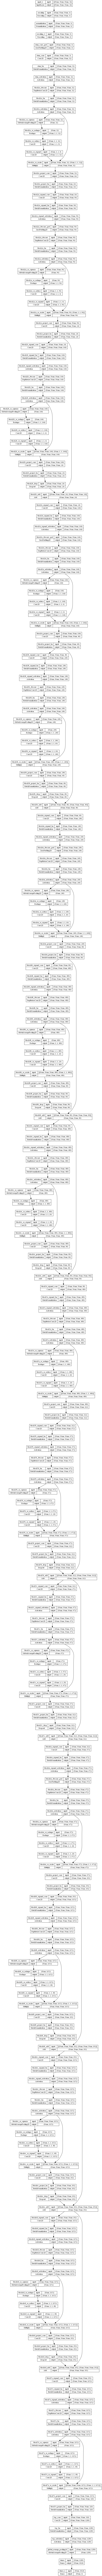

In [30]:
visualize_model(feature_extraction_model,'feature_extraction_efficientNetB0_TF.png')

> ### 7.3.9 Making predections on the test set

In [193]:
feature_extraction_preds = feature_extraction_model.evaluate(test_data)
print ("Loss = " + str(feature_extraction_preds[0]))
print ("Test Accuracy = " + str(feature_extraction_preds[1]))

94/94 [==============================] - 94s 1s/step - loss: 0.3313 - accuracy: 0.8963
Loss = 0.3313460350036621
Test Accuracy = 0.8963333368301392


> ## 7.4 Fine-tuning

> ### 7.4.1 Base model VGG16

In [31]:
fine_tuning_base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
for layer in fine_tuning_base_model.layers:
    layer.trainable = False

> ### 7.4.2 Adding output layers

In [32]:
x = Flatten()(fine_tuning_base_model.output)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(6, activation='softmax')(x)

fine_tuning_model = Model(inputs=fine_tuning_base_model.input, outputs=predictions)

> ### 7.4.3 Unfreeze the last 15 layers for training 

In [33]:
for layer in fine_tuning_model.layers[:15]:
    layer.trainable = False
for layer in fine_tuning_model.layers[15:]:
    layer.trainable = True

> ### 7.4.4 Compile the model

In [34]:
fine_tuning_model.compile(optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"],
              loss='categorical_crossentropy')

> ### 7.4.5 Create callbacks

In [35]:
fine_tuning_callbacks = get_callbacks('fine_tuning_vgg16_checkpoints.ckpt')

> ### 7.4.6 Fit the model

In [36]:
ft_start_time = time.time()

fine_tuning_model_history = fine_tuning_model.fit(
    train_data,
    epochs=4,
    steps_per_epoch=len(train_data),
    validation_data=validation_data,
    validation_steps=len(validation_data),
    callbacks=feature_extraction_callbacks,
    class_weight=class_weights
)

ft_end_time = time.time()

Epoch 1/4
132/132 [==============================] - ETA: 0s - loss: 0.8169 - accuracy: 0.6687
Epoch 1: val_accuracy improved from -inf to 0.80711, saving model to feature_extractor_efficientNetB0_checkpoints.ckpt
132/132 [==============================] - 373s 3s/step - loss: 0.8169 - accuracy: 0.6687 - val_loss: 0.4951 - val_accuracy: 0.8071 - lr: 0.0010
Epoch 2/4
132/132 [==============================] - ETA: 0s - loss: 0.4210 - accuracy: 0.8524
Epoch 2: val_accuracy improved from 0.80711 to 0.87208, saving model to feature_extractor_efficientNetB0_checkpoints.ckpt
132/132 [==============================] - 387s 3s/step - loss: 0.4210 - accuracy: 0.8524 - val_loss: 0.3792 - val_accuracy: 0.8721 - lr: 0.0010
Epoch 3/4
132/132 [==============================] - ETA: 0s - loss: 0.3236 - accuracy: 0.8875
Epoch 3: val_accuracy did not improve from 0.87208
132/132 [==============================] - 435s 3s/step - loss: 0.3236 - accuracy: 0.8875 - val_loss: 0.4331 - val_accuracy: 0.8589 -

**Time taken for training**

In [37]:
ft_time_taken = ft_end_time - ft_start_time
print("Time taken: ", ft_time_taken)

Time taken:  1610.099962234497


> ### 7.4.7 Plotting the loss curves

In [38]:
plot_loss_curves(fine_tuning_model_history)

![Alt text](vgg16_tf.png)

> ### 7.4.8 Loading the best saved weights

In [39]:
#fine_tuning_model.load_weights('fine_tuning_vgg16_checkpoints.ckpt')

> ### 7.4.9 Pottling the model architecture

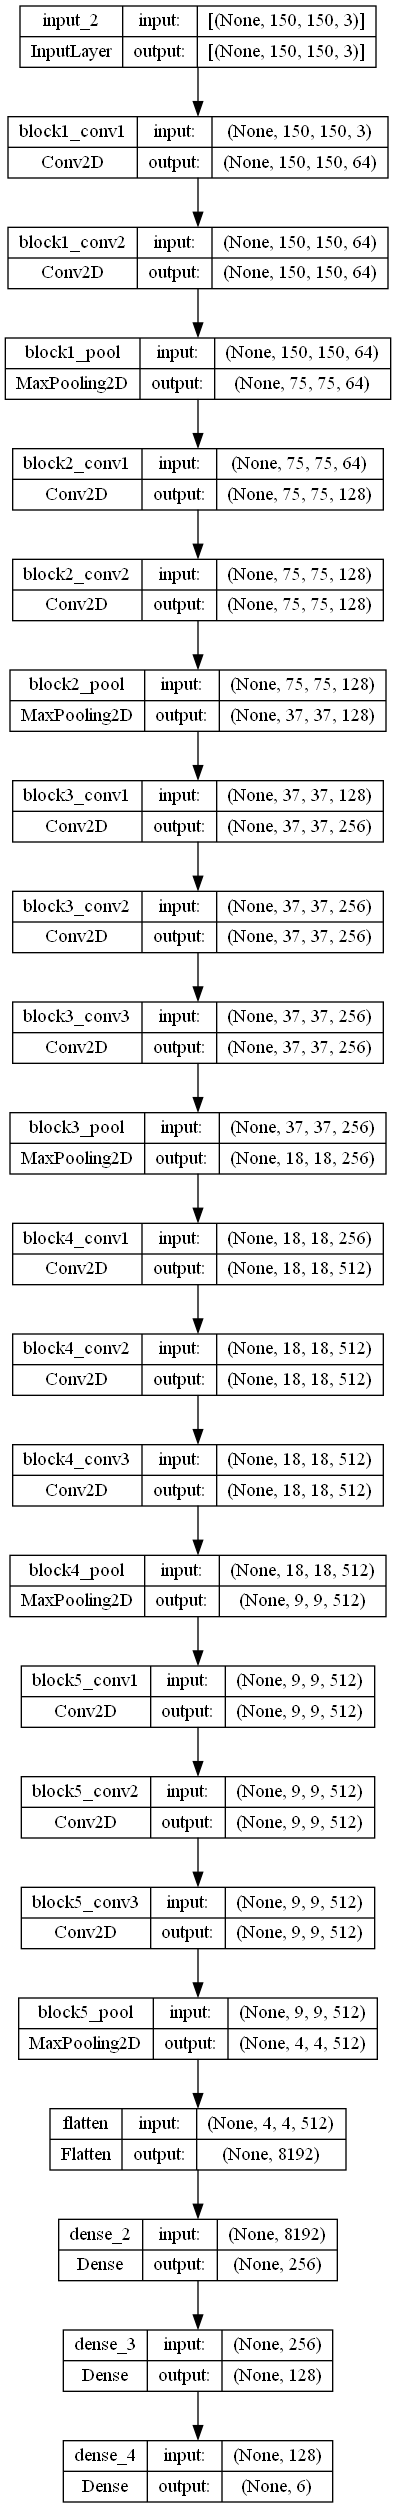

In [40]:
visualize_model(fine_tuning_model,'fine_tuning_vgg16_TF.png')

> ### 7.4.10 Making predections on the test set

In [41]:
fine_tuning_preds = fine_tuning_model.evaluate(test_data)
print ("Loss = " + str(fine_tuning_preds[0]))
print ("Test Accuracy = " + str(fine_tuning_preds[1]))

94/94 [==============================] - 195s 2s/step - loss: 0.3736 - accuracy: 0.8680
Loss = 0.3735648989677429
Test Accuracy = 0.8679999709129333


> # Consolusion